# Tests
I want to test the classification via the reversed condition $\frac{\sigma_n}{\sigma_1}$ on some examples. We only consider the first derivative here
1. $exp(at + x)$ solves $u_t=au=au_x$
2. $cos(at - x)$ solves $u_t=-au_x$
3. $-sin(at - x)$ solves $u_t=-au_x$
4. $(at + x)exp(b t)$ solves $u_t=au_x + bu$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd
import pandas as pd
import pysindy as ps
import os
import sys
sys.path.append('../')
from test_data import *
from error_bounds import *
from sfranco_analysis.py import *

SyntaxError: invalid syntax (sfranco_analysis.py, line 110)

## Try it for one specific problem

In [3]:
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
#print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1


In [4]:
"""
n_samples=100T,X,t,x = create_data_2d(T_start=0.01, T_end=0.02, L_x_start=0.02,L_x_end=0.1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()#*1e-6

b=0
u = np.cos(b*X-a*T)
ux = -b*np.sin(b*X-a*T)
uxx = -b*b*np.cos(b*X-a*T)
uxxx = b*b*b*np.sin(b*X-a*T)
ut=p.sin(b*X-a*T)

a=1.0
b=1000.0
c=1e-5
u = (c*X+b*T)*np.exp(X+a*T)
ux = c*np.exp(X+a*T) +u
uxx = u
uxxx = u
ut = -a*u

a=1
u=1.0/(X+T)
ux=-1.0/((X+T)*(X+T))
ut=ux
dx=x[1]-x[0]
print(f"{dx:2.3e}")

u_flat, u_x_flat = u.flatten(), ux.flatten()
g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
sv=svd(g, compute_uv=False)
print(f"Singular values: {sv}")
print(f"Reversed condition: {sv[-1]/sv[0]}")

"""

'\nn_samples=100T,X,t,x = create_data_2d(T_start=0.01, T_end=0.02, L_x_start=0.02,L_x_end=0.1, N_t=n_samples, N_x=n_samples)\na=np.random.randn()#*1e-6\n\nb=0\nu = np.cos(b*X-a*T)\nux = -b*np.sin(b*X-a*T)\nuxx = -b*b*np.cos(b*X-a*T)\nuxxx = b*b*b*np.sin(b*X-a*T)\nut=p.sin(b*X-a*T)\n\na=1.0\nb=1000.0\nc=1e-5\nu = (c*X+b*T)*np.exp(X+a*T)\nux = c*np.exp(X+a*T) +u\nuxx = u\nuxxx = u\nut = -a*u\n\na=1\nu=1.0/(X+T)\nux=-1.0/((X+T)*(X+T))\nut=ux\ndx=x[1]-x[0]\nprint(f"{dx:2.3e}")\n\nu_flat, u_x_flat = u.flatten(), ux.flatten()\ng = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)\nsv=svd(g, compute_uv=False)\nprint(f"Singular values: {sv}")\nprint(f"Reversed condition: {sv[-1]/sv[0]}")\n\n'

In [4]:
result= pd.DataFrame(columns=["noise_level","order","ratio","threshold_approx_uniq","threshold_exact_uniq","threshold_approx_nonuniq","threshold_exact_nonuniq","sv_max","sv_min","C","C1","C2"])
M=infinity_norm(u)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))
C2_param=1e-4

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    # Need intitial value for C,C1 and C2
    ux_noise = ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    sv = svd(g_noise, compute_uv=False)

    #Choose C,C1,C2
    # For uniqueness classification
    C=sv[0]*0.5 #<=sv_max
    # For non-uniqueness classification
    C1=sv[0]*1.5 #>=sv_max
    C2=max(C2_param*1e-02,sv[-1]*0.5)#<=sv_min
    
    print(f"Current sv_max,sv_min: {sv[0]:.3e}, {sv[-1]:.3e}")
    print(f"For Non-Uniquness: \t \t C = {C:.3e} <= true_sv_max")
    print(f"For Uniqueness: \t C1 = {C1:.3e} >= true_sv_max")
    print(f"\t \t \t C2 = {C2:.3e} <= true_sv_min")

    for order in orders:      
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[-1]/sv[0]
        #print(u_x_flat_noise)
        #print(f"Order: {order}, Noise {noise_level}, sv {sv}")

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2=np.sqrt( error_bound_g(eps_two,eps_infty,dx,u.shape[0],order, max_order_derivative=1,Cu=M,Cxi=1.0))
        #E2=np.sqrt( error_bound_g(eps_two,eps_infty,dx,u.shape[0],order, max_order_derivative=1,Cu=1.0,Cxi=1.0))
        
        threshold_approx_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold_exact_uniq =  calc_threshold_uniq(C1,C2,E2)
  
        threshold_approx_nonuniq = calc_threshold_nonuniq(E1,C)
        threshold_exact_nonuniq = calc_threshold_nonuniq(E2,C)

        result.loc[len(result.index)] = [noise_level,order,ratio,threshold_approx_uniq,threshold_exact_uniq,threshold_approx_nonuniq,threshold_exact_nonuniq,sv[0],sv[-1],C,C1,C2]

Current sv_max,sv_min: 3.441e+05, 3.227e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For Uniqueness: 	 C1 = 5.161e+05 >= true_sv_max
	 	 	 C2 = 1.614e+02 <= true_sv_min
Current sv_max,sv_min: 3.441e+05, 3.227e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For Uniqueness: 	 C1 = 5.161e+05 >= true_sv_max
	 	 	 C2 = 1.614e+02 <= true_sv_min
Current sv_max,sv_min: 3.441e+05, 3.227e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For Uniqueness: 	 C1 = 5.161e+05 >= true_sv_max
	 	 	 C2 = 1.614e+02 <= true_sv_min
Current sv_max,sv_min: 3.441e+05, 3.227e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For Uniqueness: 	 C1 = 5.161e+05 >= true_sv_max
	 	 	 C2 = 1.614e+02 <= true_sv_min
Current sv_max,sv_min: 3.441e+05, 3.228e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For Uniqueness: 	 C1 = 5.161e+05 >= true_sv_max
	 	 	 C2 = 1.614e+02 <= true_sv_min
Current sv_max,sv_min: 3.441e+05, 3.227e+02
For Non-Uniquness: 	 	 C = 1.720e+05 <= true_sv_max
For 

In [5]:
#Save results
# Creating the directory if it doesn't exist
directory_path="results/" + experiment_name
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    
result.to_csv(directory_path+"/results.csv")

### Use distance for classification

Instead of using only the ratio it makes sense to incorparte the distance from the actual threshold(they should not be classified in the same way if one is farer away and the other is not).
For this puropose we will choose the classification with minimal distance <br>
**For Uniqueness:** <br>
We want that: ratio>threshold
So we sum up $$\frac{1}{N} \sum_{i:order}  threshold_i -ratio_i$$
If $ratio_i$ fulfills the condition for uniqueness it will be smaller 0. 
<br>
**For Non-uniqueness:** <br>
We want that: ratio<threshold
So we sum up $$\frac{1}{N}\sum_{i:order} ratio_i - threshold_i$$
If $ratio_i$ fulfills the condition for non-uniqueness it will be smaller 0. 
Does it make sense to allow negative disntance? Or should we set everything above/below Threshold to zero?<br>
Problem: for values below a threshold they count less than distances above a low threshold-> got rid of order=1


In [7]:
classification_df = pd.DataFrame({"threshold_approx_uniq":result.groupby('noise_level').apply(lambda group: (group['threshold_approx_uniq'] - group['ratio']).mean()),
             "threshold_exact_uniq":result.groupby('noise_level').apply(lambda group: ( group['threshold_exact_uniq'] - group['ratio']).mean()),
             "threshold_approx_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] -group['threshold_approx_nonuniq']).mean()),
             "threshold_exact_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] - group['threshold_exact_nonuniq']).mean())})
#Classify nonunique or uniqueness according to majority of nonunique or uniqueness
classification_df ["Classification_approx"]=classification_df.apply(lambda row: "unique" if row['threshold_approx_nonuniq'] > row['threshold_approx_uniq'] else( "nonunique" if row['threshold_approx_nonuniq'] < row['threshold_approx_uniq'] else None), axis=1)
classification_df ["Classification_exact"]=classification_df.apply(lambda row: "unique" if row['threshold_exact_nonuniq'] > row['threshold_exact_uniq'] else( "nonunique" if row['threshold_exact_nonuniq'] < row['threshold_exact_uniq'] else None), axis=1)
classification_df ["ClassificationTrue"]=classify_string(experiment_name)


classification_df.to_csv(directory_path+"/classification.csv")

No handles with labels found to put in legend.


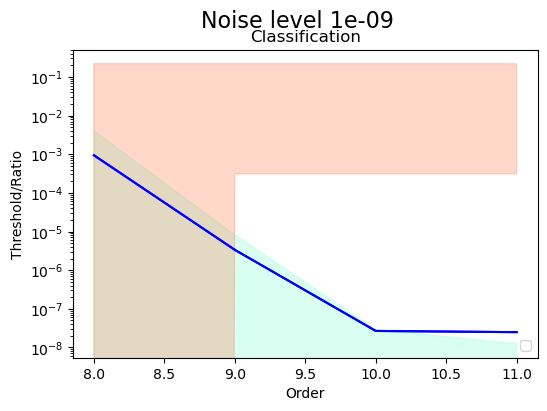

In [8]:
# Create subplots
noise_level=1e-09
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
fig.suptitle(f'Noise level {noise_level}', fontsize=16)
df = result[result["noise_level"] == noise_level]

# Subplot 1: ratio and green lines
ax.set_title("Classification")
ax.plot(df["ratio"],color='blue')
#ax1.plot( df["ratio"]-df["threshold_approx_nonuniq"], 'x', label='diff approx', color='green')
#ax1.plot( df["ratio"]-df["threshold_exact_nonuniq"], 'o', label='dff exact', color='green')

#ax1.plot( df["threshold_approx_nonuniq"], '--', label='Threshold approx', color='green')
#ax1.plot(df["threshold_exact_nonuniq"], ':', label='Threshold exact', color='aquamarine')
#ax.fill_between(df.index, 0, df["threshold_approx_nonuniq"], color='green', alpha=0.3)
ax.fill_between(df.index, 0, df["threshold_exact_nonuniq"], color='aquamarine', alpha=0.3)
ax.set_ylabel('Threshold/Ratio')

#ax2.plot( df["threshold_approx_uniq"]-df["ratio"], 'x', label='diff approx', color='green')
#ax2.plot( df["threshold_exact_uniq"]-df["ratio"], 'o', label='dff exact', color='green')

ax.plot(df["ratio"],color='blue')
#ax2.plot( df["threshold_approx_uniq"], '--', label='Threshold approx', color='red')
#ax2.plot( df["threshold_exact_uniq"], ':', label='Threshold exact', color='coral')
#ax.fill_between(df.index, df["threshold_approx_uniq"], y2=result.ratio.max(), color='red', alpha=0.3)
ax.fill_between( df.index, df["threshold_exact_uniq"], y2=result.ratio.max(), color='coral', alpha=0.3)
ax.set_yscale('log')

ax.set_xlabel('Order')
ax.legend(loc=4)

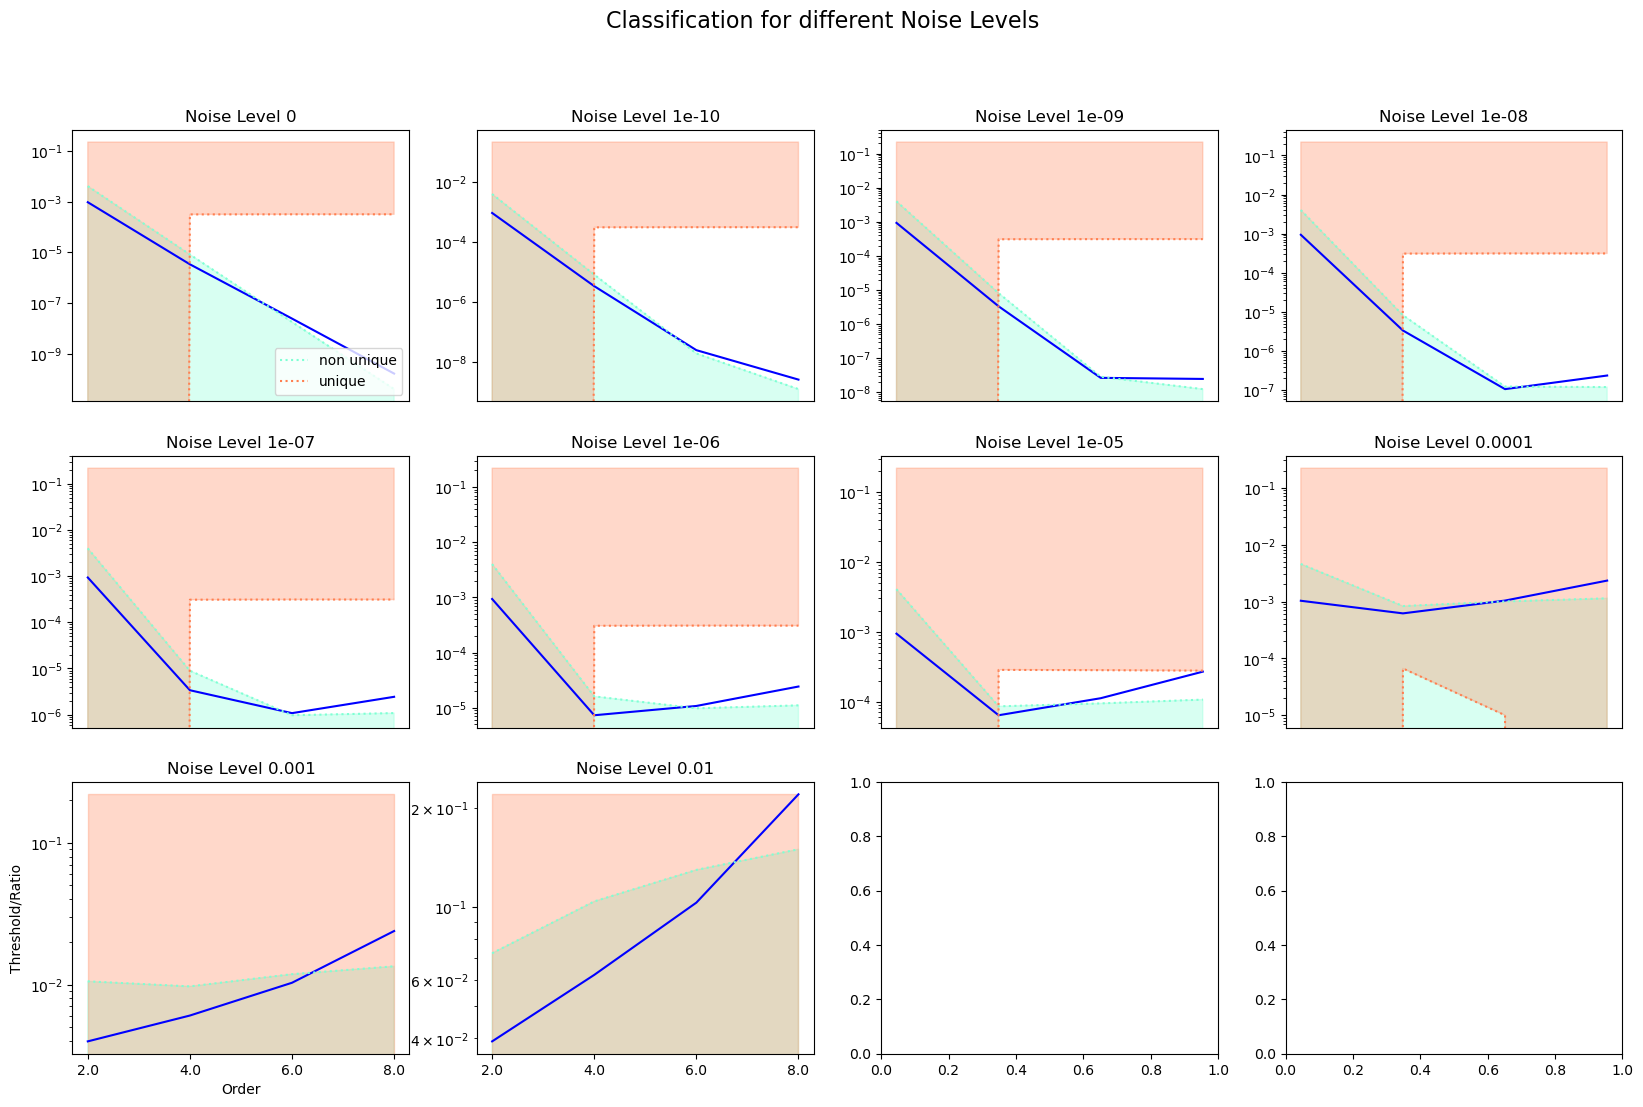

In [9]:
plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png")

### Try different C

In [10]:
C_choices = [0.3,0.5,0.7,0.9,1]
C1_choices = [1.0,1.2,1.5,1.7,2]
C2_choices = [0.5,0.7,0.9]
eps_choices=[1e-02,1e-04,1e-06,1e-08]

In [11]:
result= pd.DataFrame(columns=["noise_level","order","ratio","threshold_exact_uniq","threshold_exact_nonuniq","sv_max","sv_min","C","C1","C2","eps"])
M=infinity_norm(u)
number_noise=10 #<=10
orders=range(2,10,2)
noise_level = 1e-08

var = noise_level * unorm2
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u-u_noise)

# Need intitial value for C,C1 and C2
ux_noise = ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()

g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
sv = svd(g_noise, compute_uv=False)

for C_scale in C_choices:
    for C1_scale in C1_choices:
        for C2_scale in C2_choices:
            for eps_choice in eps_choices:
                # For uniqueness classification
                C=sv[0]*C_scale #<=sv_max
                # For non-uniqueness classification
                C1=sv[0]*C1_scale #>=sv_max
                C2=max(eps_choice,sv[-1]*C2_scale)#<=sv_min

                print(f"Current sv_max,sv_min: {sv[0]:.3e}, {sv[-1]:.3e}")
                print(f"For Non-Uniquness: \t \t C = {C:.3e} <= true_sv_max")
                print(f"For Uniqueness: \t C1 = {C1:.3e} >= true_sv_max")
                print(f"\t \t \t C2 = {C2:.3e} <= true_sv_min")

                for order in orders:      
                    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
                    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
                    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
                    sv = svd(g_noise, compute_uv=False)
                    ratio=sv[-1]/sv[0]
            
                
                    #Potential upper bounds for |G-G_noise| 
                    #E1=np.sqrt(eps_infty/dx+dx**order)
                    E2=np.sqrt( error_bound_g(eps_two,eps_infty,dx,u.shape[0],order, max_order_derivative=1,Cu=M,Cxi=1.0))
                    #E2=np.sqrt( error_bound_g(eps_two,eps_infty,dx,u.shape[0],order, max_order_derivative=1,Cu=1.0,Cxi=1.0))
                    
                    #threshold_approx_uniq =  calc_threshold_uniq(C1,C2,E1)
                    threshold_exact_uniq =  calc_threshold_uniq(C1,C2,E2)
                
                    #threshold_approx_nonuniq = calc_threshold_nonuniq(E1,C)
                    threshold_exact_nonuniq = calc_threshold_nonuniq(E2,C)
                
                    result.loc[len(result.index)] = [noise_level,order,ratio,threshold_exact_uniq,threshold_exact_nonuniq,sv[0],sv[-1],C_scale,C1_scale,C2_scale,eps_choice]

Current sv_max,sv_min: 1.263e+03, 1.185e+00
For Non-Uniquness: 	 	 C = 3.790e+02 <= true_sv_max
For Uniqueness: 	 C1 = 1.263e+03 >= true_sv_max
	 	 	 C2 = 5.925e-01 <= true_sv_min
Current sv_max,sv_min: 1.263e+03, 3.231e-04
For Non-Uniquness: 	 	 C = 3.788e+02 <= true_sv_max
For Uniqueness: 	 C1 = 1.263e+03 >= true_sv_max
	 	 	 C2 = 1.616e-04 <= true_sv_min
Current sv_max,sv_min: 1.263e+03, 3.231e-04
For Non-Uniquness: 	 	 C = 3.788e+02 <= true_sv_max
For Uniqueness: 	 C1 = 1.263e+03 >= true_sv_max
	 	 	 C2 = 1.616e-04 <= true_sv_min
Current sv_max,sv_min: 1.263e+03, 3.231e-04
For Non-Uniquness: 	 	 C = 3.788e+02 <= true_sv_max
For Uniqueness: 	 C1 = 1.263e+03 >= true_sv_max
	 	 	 C2 = 1.616e-04 <= true_sv_min
Current sv_max,sv_min: 1.263e+03, 3.231e-04
For Non-Uniquness: 	 	 C = 3.788e+02 <= true_sv_max
For Uniqueness: 	 C1 = 1.263e+03 >= true_sv_max
	 	 	 C2 = 1.000e-02 <= true_sv_min
Current sv_max,sv_min: 1.263e+03, 3.231e-04
For Non-Uniquness: 	 	 C = 3.788e+02 <= true_sv_max
For 

In [12]:
N=len(set(result['C'].values))
reds = [plt.get_cmap("tab20b")(13+i) for i in range(N)] 
greens = [plt.get_cmap("tab20b")(5+i) for i in range(len(eps_choices))] 
unique_C_values = sorted(set(result['C'].values))

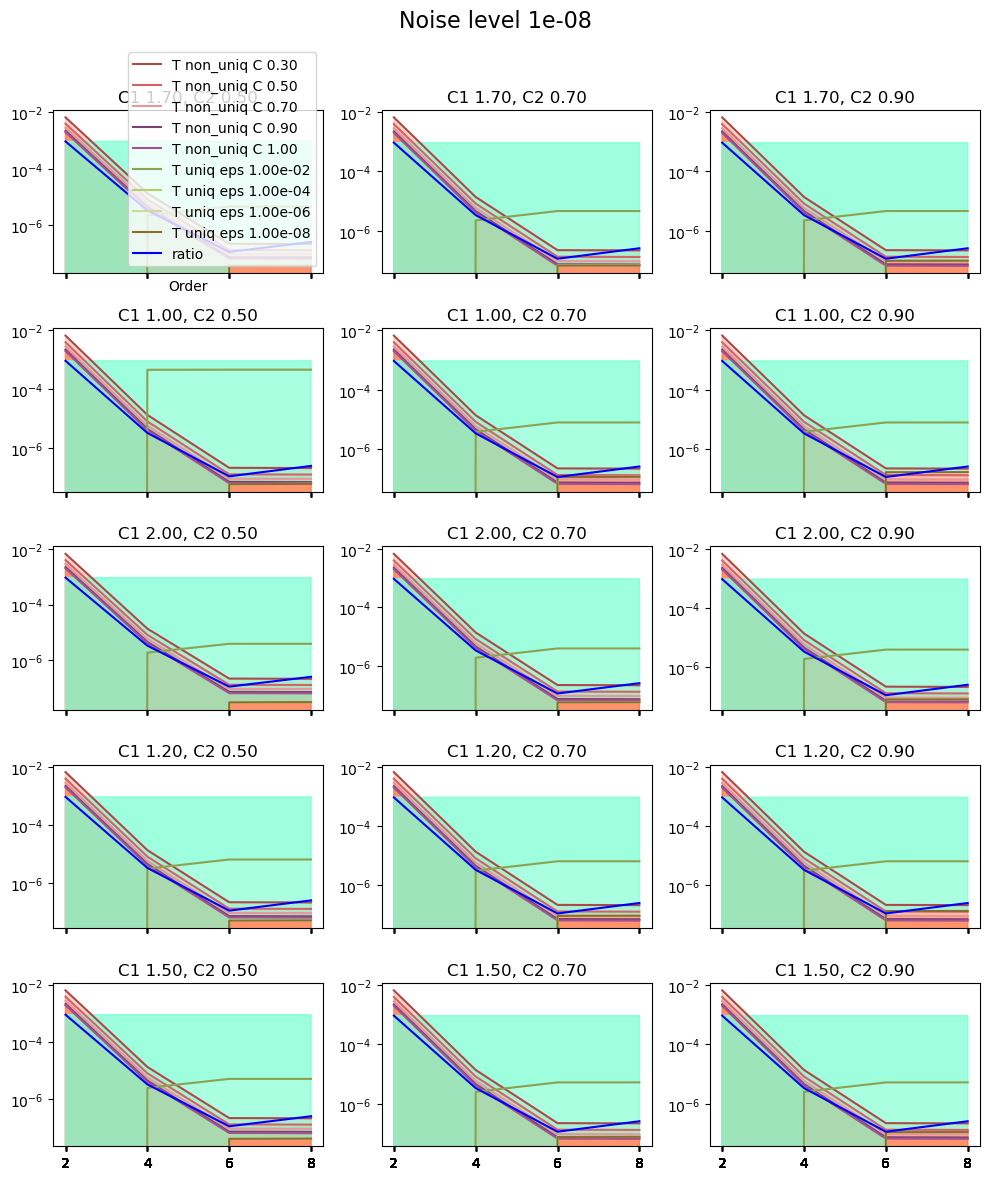

In [13]:
N1=len(set(result['C1'].values))
N2=len(set(result['C2'].values))
fig, axs = plt.subplots(N1,N2, sharex=True, figsize=(2*N1, 4*N2))
fig.suptitle(f'Noise level {noise_level}', fontsize=16)

for i, C1 in enumerate(set(result['C1'].values)):
    df_C1 = result.query(f'C1 == {C1}')
    for j, C2 in enumerate(set(df_C1['C2'].values)):
        df_C2 = df_C1.query(f'C2 == {C2}') 
        axs[i, j].set_title(f'C1 {C1:.2f}, C2 {C2:.2f}')
        axs[i, j].set_xticks(df_C2["order"].values)

        for k, C in enumerate(unique_C_values):
            #print(C1, C2, C)
            df_C = df_C2.query(f'C == {C} and eps == {eps_choices[0]}')
            axs[i, j].plot(df_C["order"].values, df_C["threshold_exact_nonuniq"].values, label=f'T non_uniq C {C:.2f}', color=reds[k])
            axs[i, j].fill_between(df_C["order"].values, df_C["threshold_exact_nonuniq"].values, color='coral', alpha=0.3)

        for l, eps in enumerate(eps_choices):
            #print(C1, C2, eps)
            df_eps = df_C2.query(f'eps == {eps} and C == {unique_C_values[0]}')
            axs[i, j].plot(df_eps["order"].values, df_eps["threshold_exact_uniq"].values, label=f'T uniq eps {eps:.2e}', color=greens[l])
            axs[i, j].fill_between(df_eps["order"].values, df_eps["threshold_exact_uniq"].values, y2=result.ratio.max(), color='aquamarine', alpha=0.3)

        axs[i, j].plot(df_C["order"].values, df_C["ratio"].values, label='ratio', color='blue')
        axs[i, j].set_yscale('log')
        
        axs[i, j].set_title(f'C1 {C1:.2f}, C2 {C2:.2f}')
        if i==0 and j==0:
            axs[i, j].legend(loc=4)
            axs[i, j].set_xlabel('Order')
            

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout to avoid title overlap
plt.show()

## Do it for all problems

### Order derivative 1

In [ ]:
for experiment_name in experiment_names:
    
    #Get data
    u,x,t,formula = experiment_data(n_samples=50,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(experiment_name)
    print(formula)
    noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
    result = get_result_df(u,dx,noise_levels,boundary=True)
    #Save results
    # Creating the directory if it doesn't exist
    directory_path="results/" + experiment_name
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    result.to_csv(directory_path+"/results.csv")

    plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png", title=f"{experiment_name} {formula}")

### Order derivative 2

linear_nonunique_1
exp(-0.61411892286398*t + x)


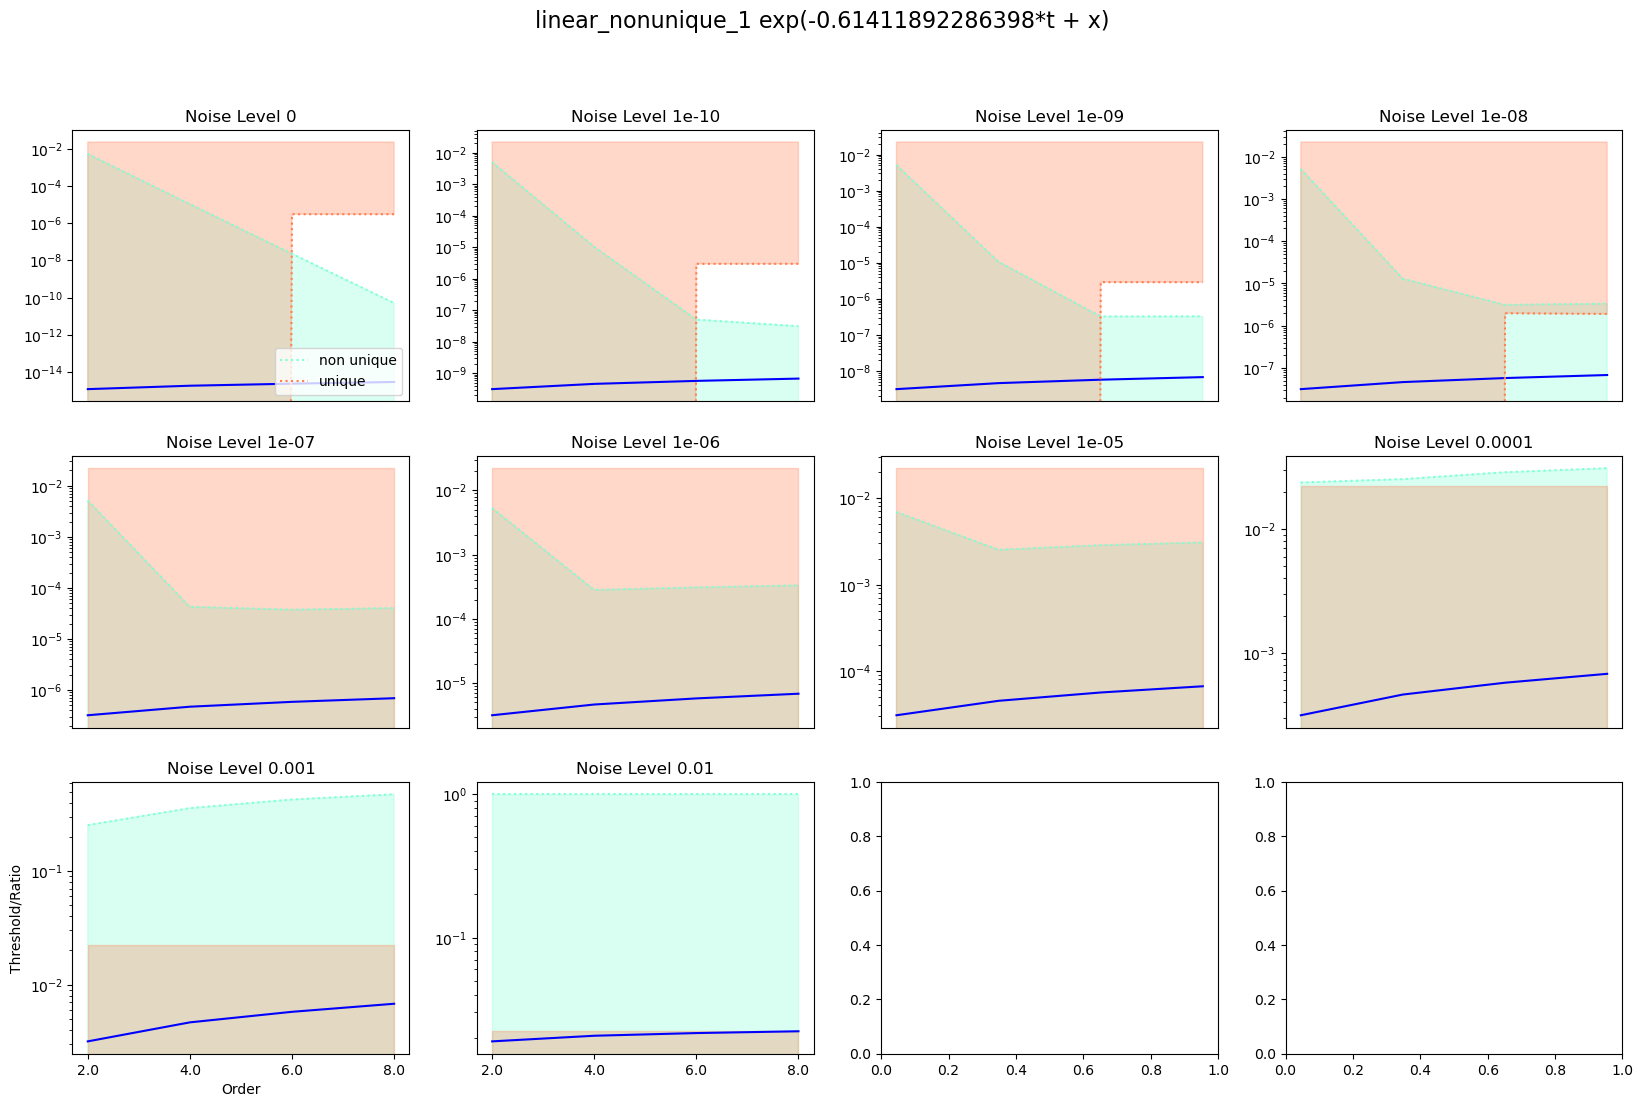

linear_unique_1.1
cos(1.12374097931679*t - x)


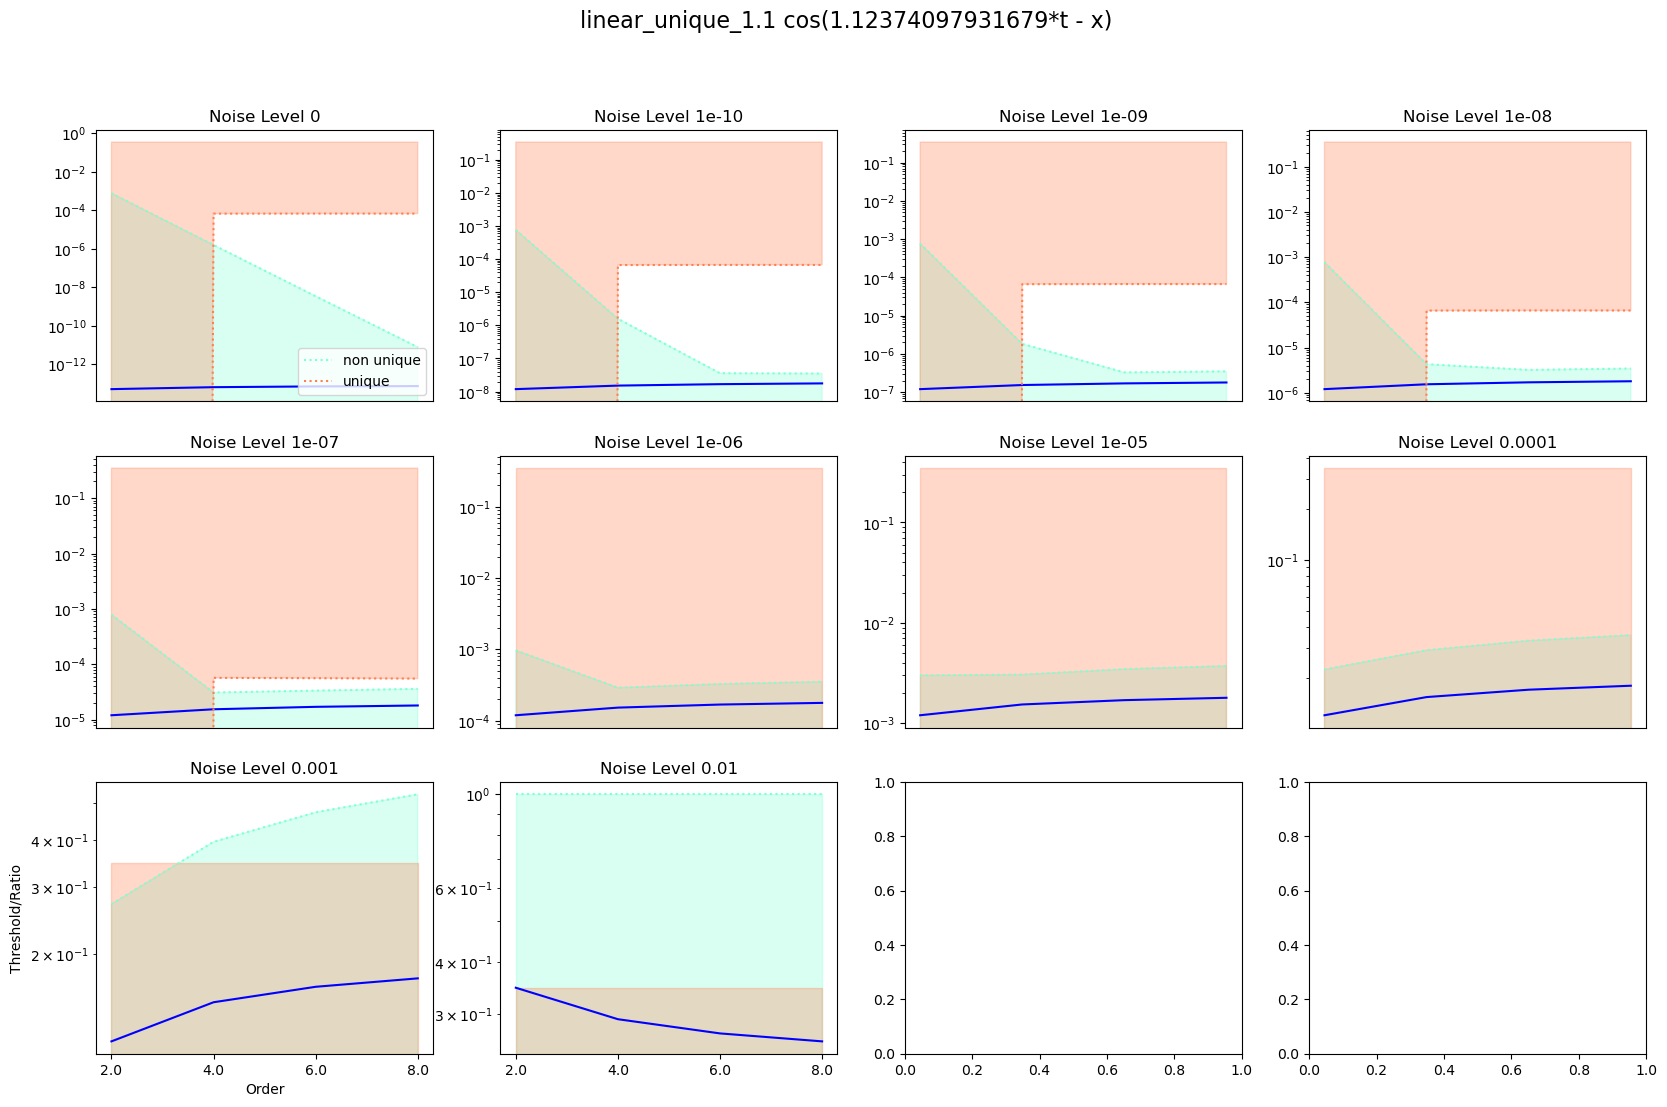

linear_unique_1.2
-sin(0.406915011440941*t - x)


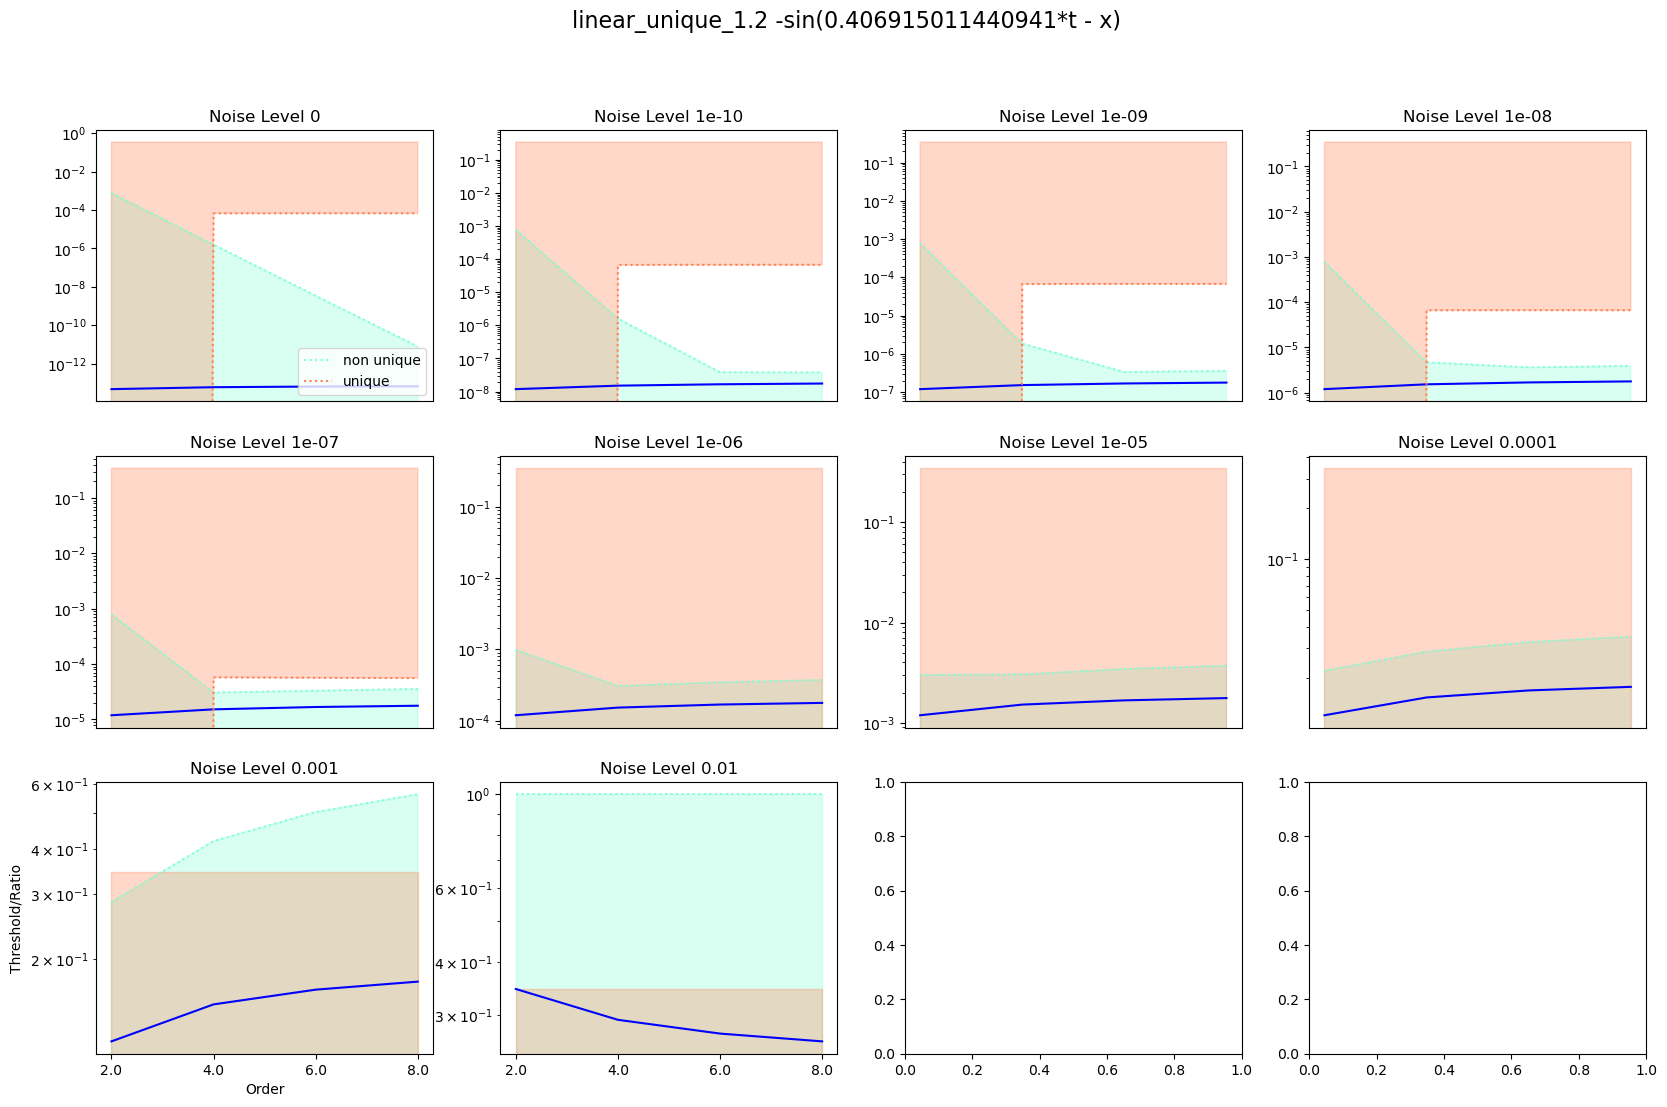

linear_unique_1.3
4*t*x - sin(0.0674333717605184*t - x) + sin(0.0674333717605184*t + x)


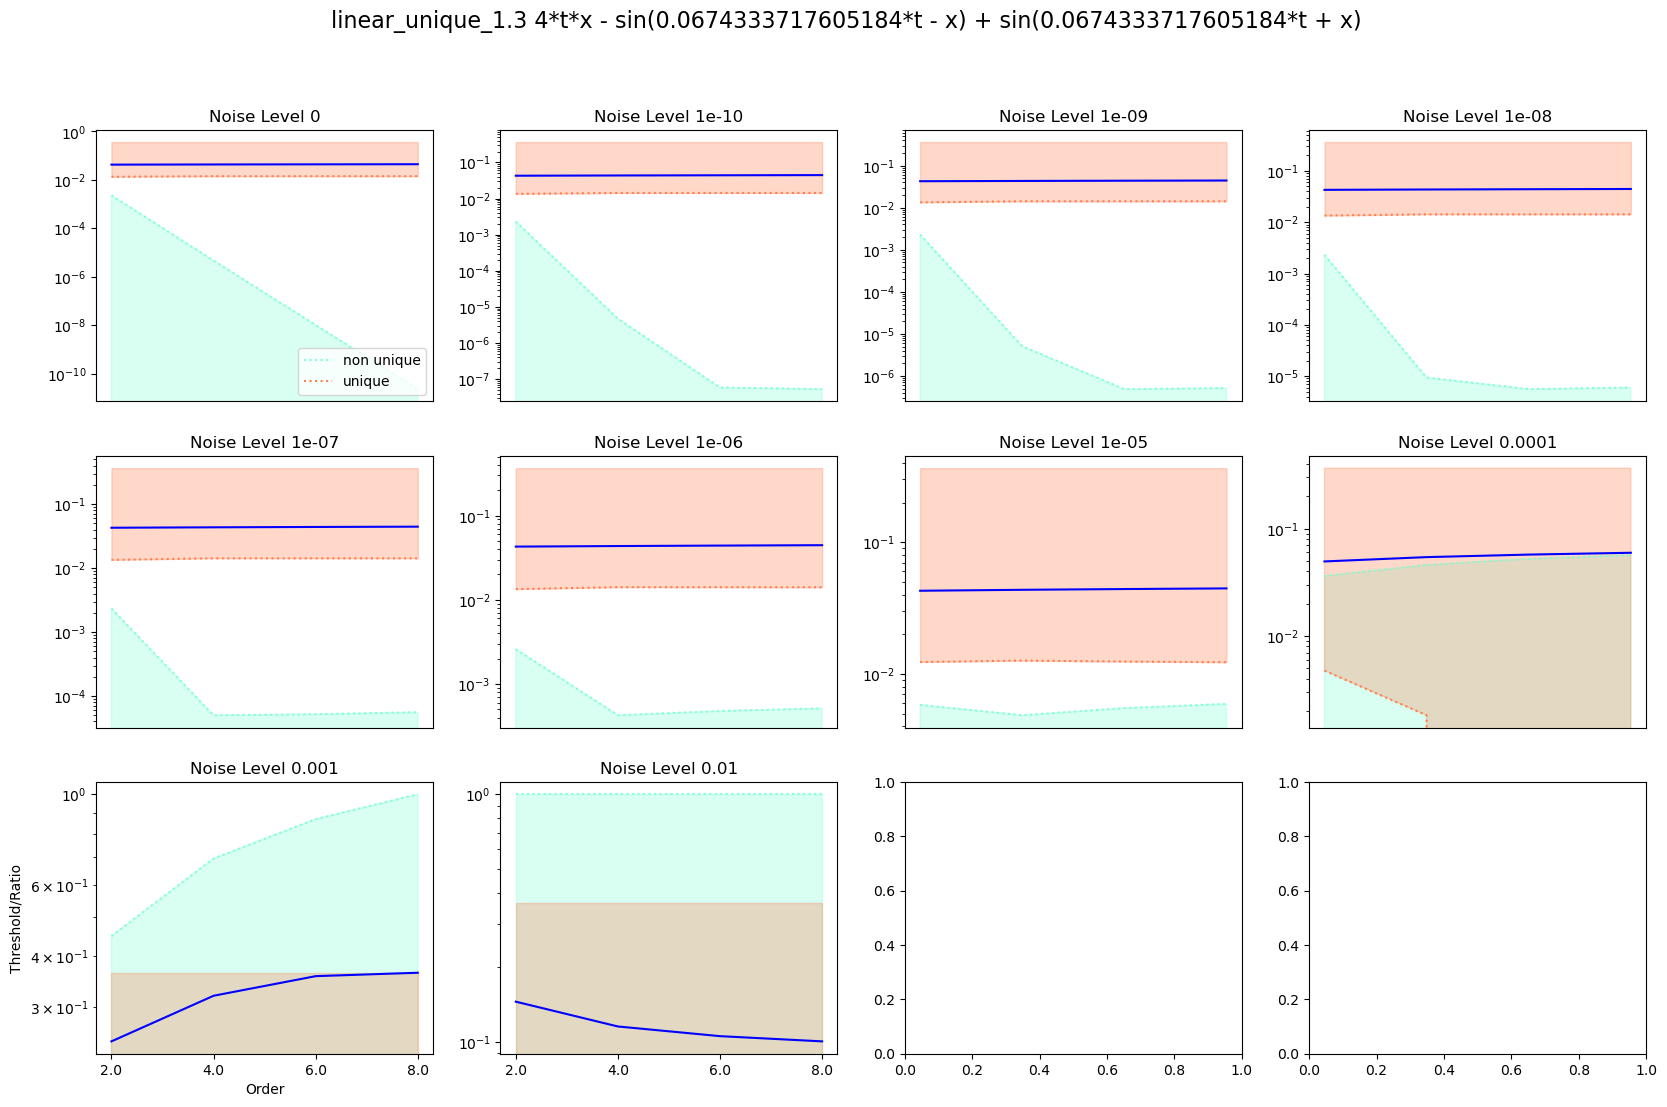

In [19]:
for experiment_name in experiment_names:   
    #Get data
    u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(experiment_name)
    print(formula)
    noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
    result = get_result_df(u,dx,noise_levels,orders=range(2,10,2),max_order_derivative=2,Cxi=1.0,boundary=True)
    #Save results
    # Creating the directory if it doesn't exist
    directory_path="results/" + experiment_name
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    result.to_csv(directory_path+"/results.csv")

    plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png", title=f"{experiment_name} {formula}")

### Order derivative 3

linear_nonunique_1
exp(-2.07942902307882*t + x)


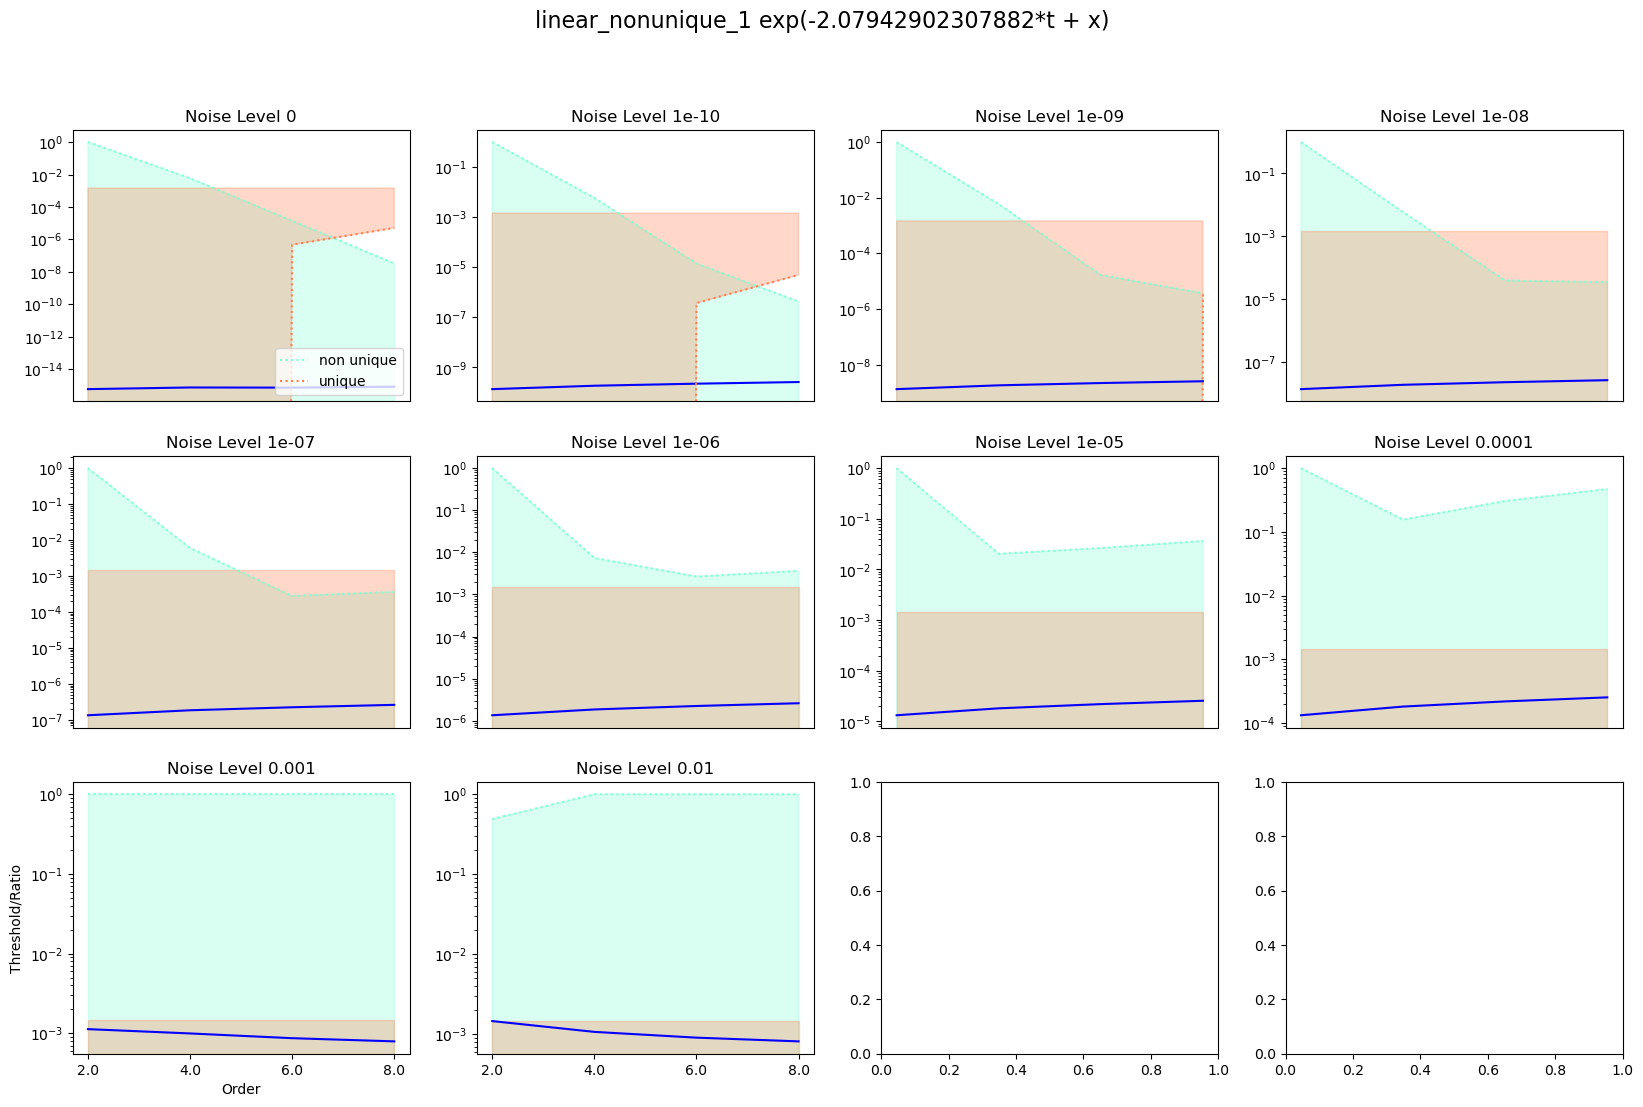

linear_unique_1.1
cos(0.828430845777535*t - x)


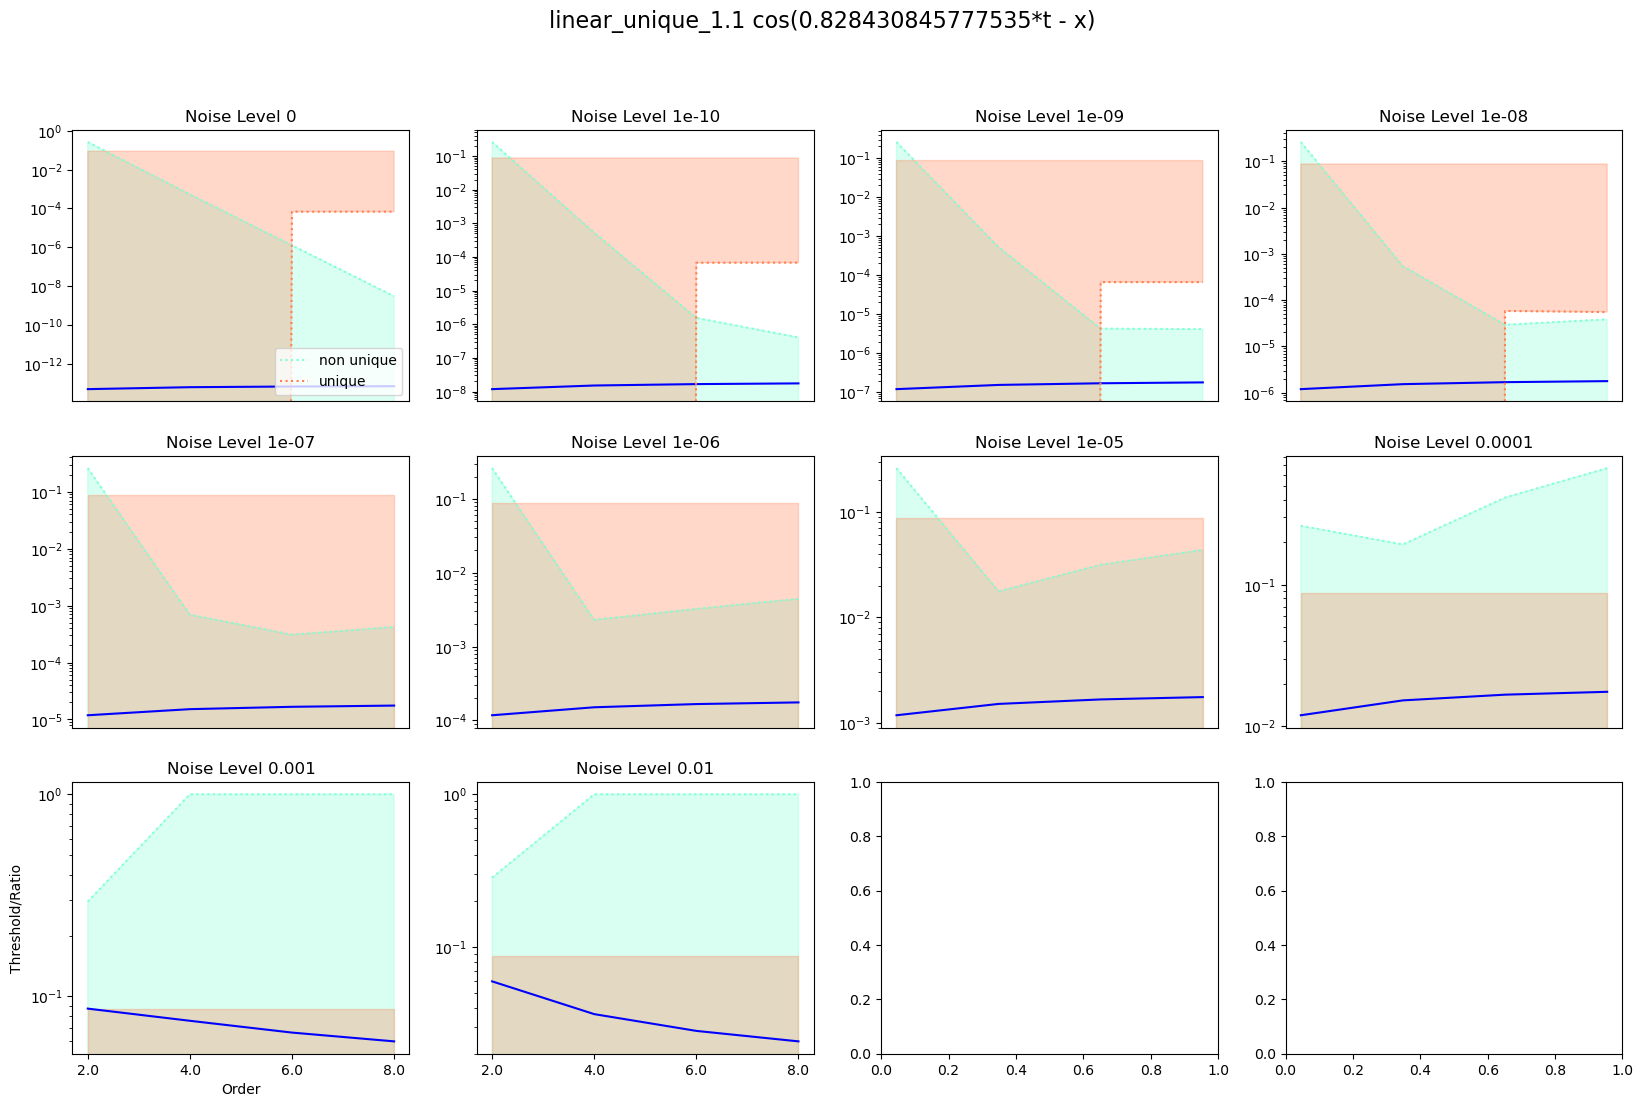

linear_unique_1.2
-sin(0.283023121398999*t - x)


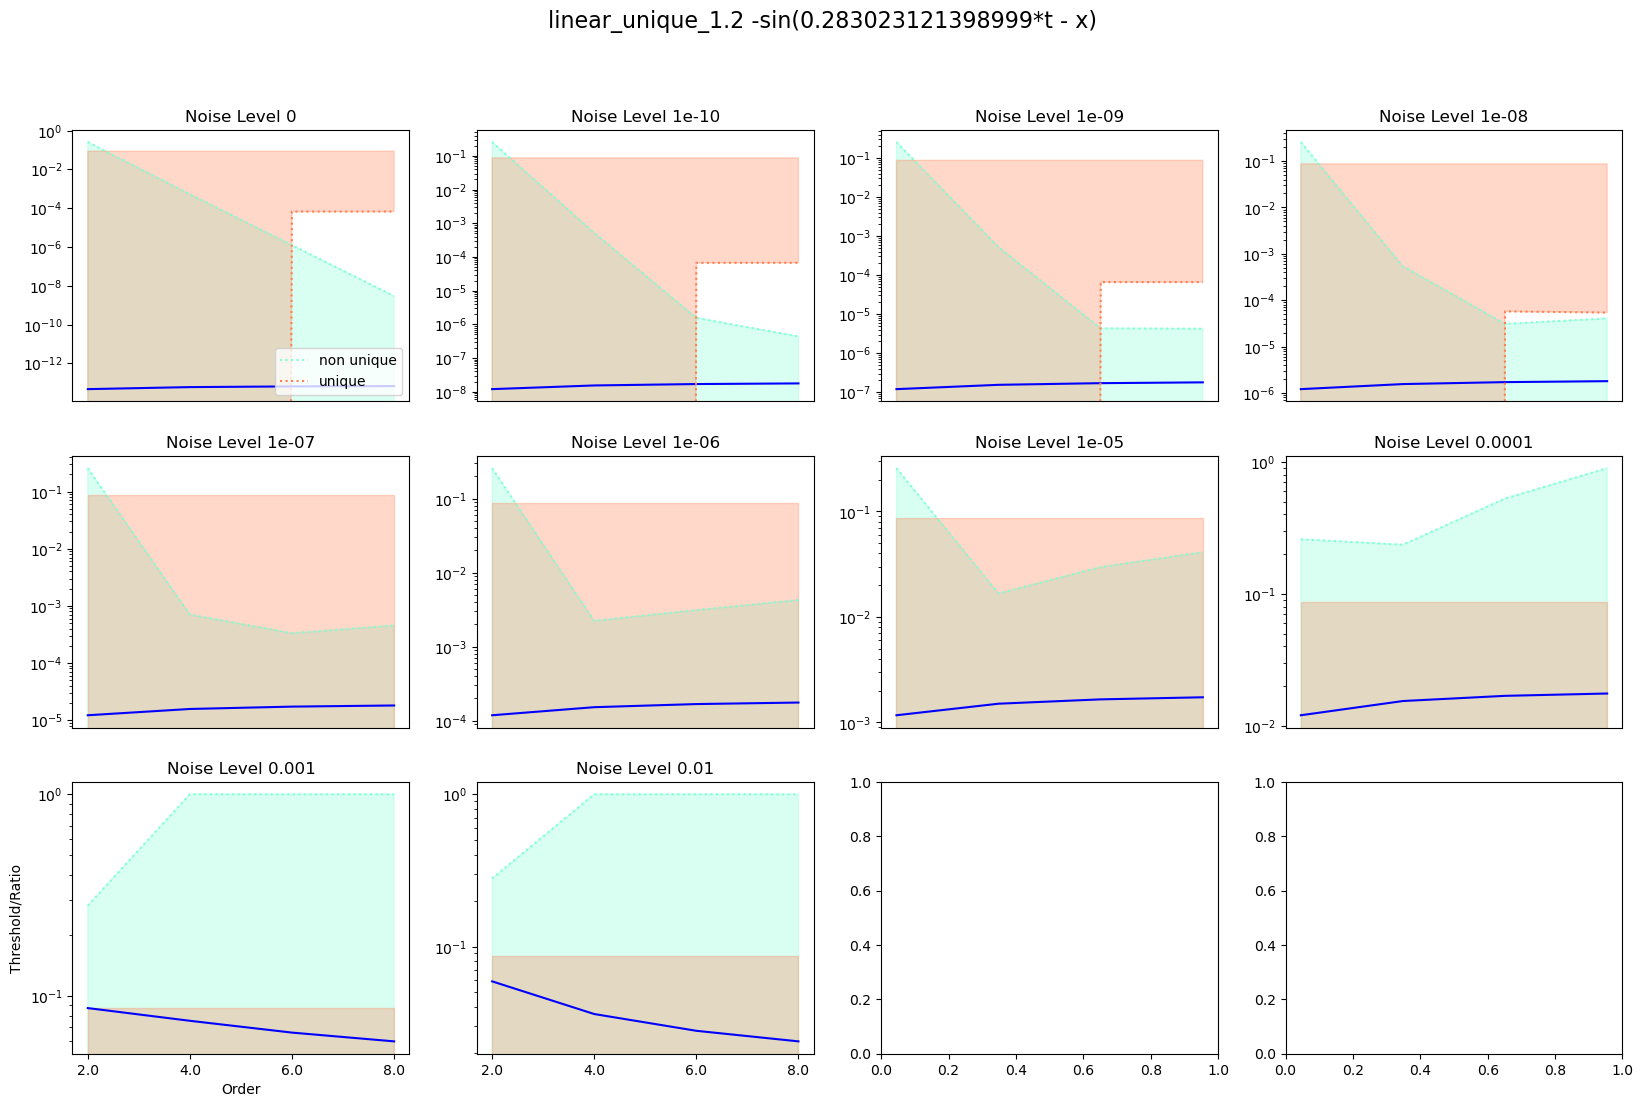

linear_unique_1.3
4*t*x - sin(1.54298821098987*t - x) + sin(1.54298821098987*t + x)


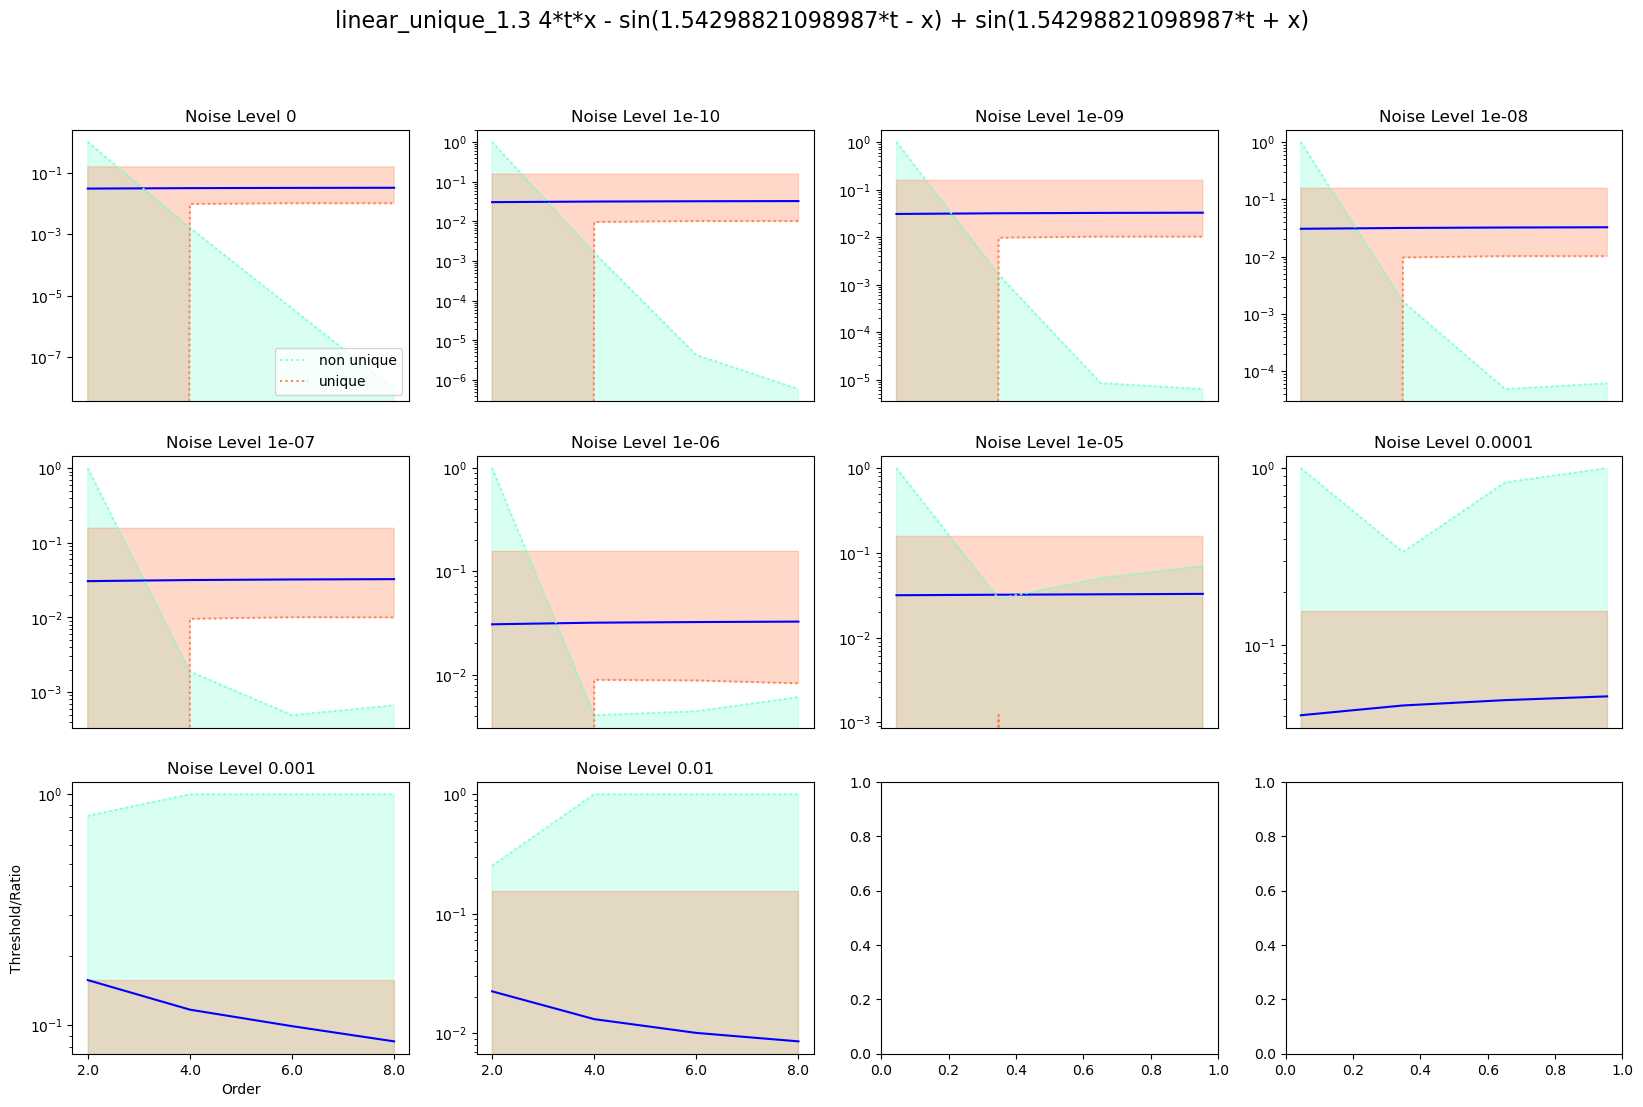

In [ ]:
for experiment_name in experiment_names:
    
    #Get data
    u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(experiment_name)
    print(formula)
    noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
    result = get_result_df(u,dx,noise_levels,orders=range(2,10,2),max_order_derivative=3,Cxi=1.0,boundary=True)
    #Save results
    # Creating the directory if it doesn't exist
    directory_path="results/" + experiment_name
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    result.to_csv(directory_path+"/results.csv")
    classification_df.to_csv(directory_path+"/classifcation.csv")
    
    plot_uniq_non_uniq_class_with_noise_levels(noise_levels,result,"results/"+experiment_name+"/classification_noise_level.png", title=f"{experiment_name} {formula}")

## Plots for paper

In [8]:
experiment_names= ['linear_nonunique_1','linear_unique_1.3']

In [40]:
result["threshold_exact_uniq"].max()

0.11826611409478224

In [49]:
max(result["ratio"].max(),result["threshold_exact_uniq"].max(),result["threshold_exact_nonuniq"].max())

0.4115472006157006

In [59]:
#Plots classification for different noise leevels
def plot_paper(noise_levels,result,image_path,title='Classification for different Noise Levels'):
    num_cols = 2
    ticksize=18
    num_rows = int(np.ceil(len(noise_levels)/num_cols))
    fig, axs = plt.subplots(num_rows, num_cols,  figsize=(5*num_cols, 4 *num_rows))
    #fig.suptitle(title, fontsize=tickssize)
    
    # Iterate over noise levels
    j=0
    for i, noise_level in enumerate(noise_levels,start=0):
        df = result[result["noise_level"] == noise_level]
        #print(i//(num_rows), j%(num_cols))
 
        axs[i//(num_rows), j%(num_cols)].set_title(f"Noise Level {noise_level}", fontsize=ticksize)
        axs[i//(num_rows), j%(num_cols)].plot(df["ratio"], color='blue',label =r"$\frac{\sigma_n}{\sigma_1}$" )
        axs[i//(num_rows), j%(num_cols)].plot(df["threshold_exact_nonuniq"], ':', label='non unique', color='aquamarine')
        axs[i//(num_rows), j%(num_cols)].fill_between(df.index, 0, df["threshold_exact_nonuniq"], color='aquamarine', alpha=0.3)

        max_val = max(result["ratio"].max(),df["threshold_exact_uniq"].max(),df["threshold_exact_nonuniq"].max())
        axs[i//(num_rows), (j)%num_cols].plot(df["threshold_exact_uniq"], ':', label='unique', color='coral')
        axs[i//(num_rows), (j)%num_cols].fill_between(df.index, df["threshold_exact_uniq"], y2=max_val, color='coral', alpha=0.3)
        axs[i//(num_rows), (j)%num_cols].set_yscale('log')
        
        #Only show legend in first plot
        if i ==0:
            axs[i//(num_rows), j%(num_cols)].legend(loc=4, fontsize=ticksize - 4)
            
        #Only show y and x label in last plot
        if i//(num_rows) == num_rows-1:
            axs[i//(num_rows), j%(num_cols)].set_xticks(df.index)
            axs[i//(num_rows), j%(num_cols)].set_xticklabels(df.order, fontsize=ticksize-2)
            if j%(num_cols) == 0: 
                #axs[i//(num_rows), j%(num_cols)].set_ylabel('Threshold/Ratio', fontsize=ticksize)
                axs[i//(num_rows), j%(num_cols)].set_xlabel('Order', fontsize=ticksize)
        else:
            #Get rid of x labels
            axs[i//(num_rows), j%(num_cols)].set_xticks([])
        
        j+=1

    # Set common labels
    for ax in axs.flat:
        ax.label_outer()
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(ticksize-2)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(ticksize-2)
            
    # Show the plot
    fig.savefig(image_path,format='svg')
    plt.show()

linear_nonunique_1
exp(-0.471435163732493*t + x)


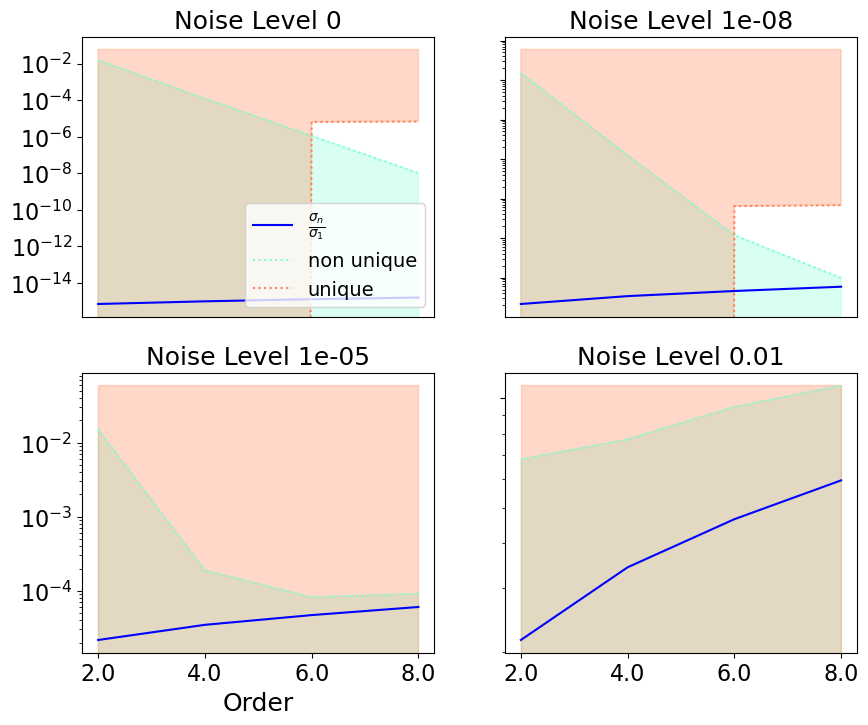

linear_unique_1.3
4*t*x - sin(0.471435163732493*t - x) + sin(0.471435163732493*t + x)


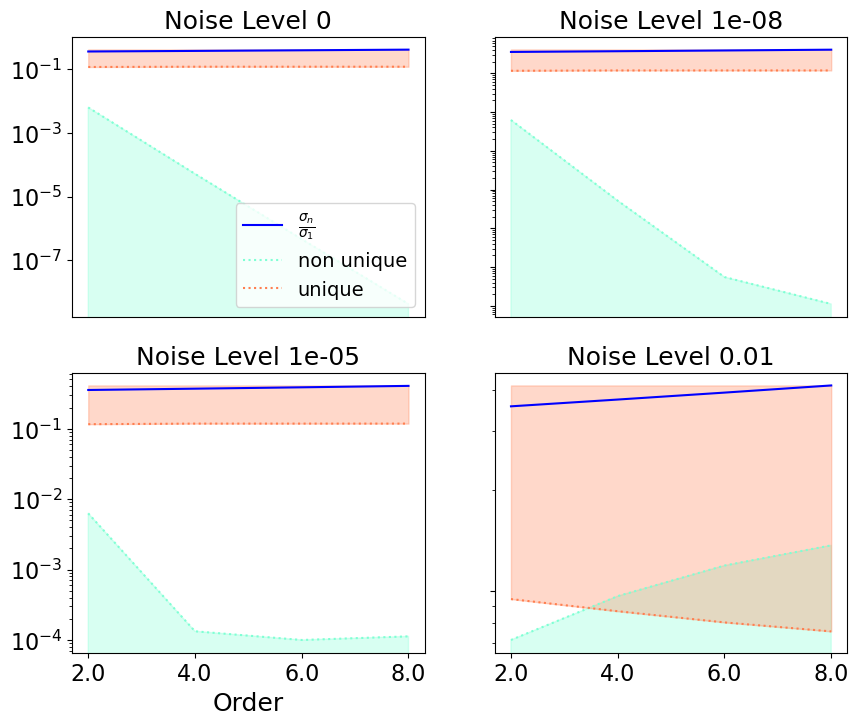

In [61]:
noise_levels = [0,1e-08,1e-05,1e-02]
for experiment_name in experiment_names:
    
    #Get data
    u,x,t,formula = experiment_data(n_samples=50,experiment_name=experiment_name)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    print(experiment_name)
    print(formula)
    
    result = get_result_df(u,dx,noise_levels,boundary=True)
    #Save results
    # Creating the directory if it doesn't exist
    directory_path="results/" + experiment_name
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    result.to_csv(directory_path+"/results.csv")

    plot_paper(noise_levels,result,"Paper/"+experiment_name+"/classification_noise_level_sfranco_paper.svg", title=f"{experiment_name} {formula}")